In [1]:
import warnings
from matplotlib.cbook import MatplotlibDeprecationWarning
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore',UnicodeWarning)


![HELP logo](https://github.com/pdh21/FIR_bootcamp_2016/blob/master/Figures/Help_Logo.png?raw=true)
# XID+
### _Peter Hurley_

1. Uses a MCMC based approach to get FULL posterior
2. Provide a natural framework to introduce additional prior information
3. Allows more accurate estimate of flux density errors for each source
4. Provides a platform for doing science with the maps (e.g Hierarchical stacking of LBGs, Luminosity function from the map etc)

![stan logo](https://github.com/stan-dev/logos/blob/master/pystan_logo_name.png?raw=true)


Cross-identification tends to be done with catalogues, then science with the matched catalogues.

XID+ takes a different philosophy.
* Catalogues are a form of data compression. OK in some cases, not so much in others: 
    - i.e. confused images: catalogue compression loses correlation information
* Ideally, science should be done without compression..

XID+ provides a framework to cross identify galaxies we know about in different maps, with the idea that it can be extended to do science with the maps!!


## Probabilistic Framework


Philosophy: 
* build a probabilistic generative model for the SPIRE maps
* Infer model on SPIRE maps


### Bayes Theorem
$p(\mathbf{f}|\mathbf{d}) \propto p(\mathbf{d}|\mathbf{f}) \times p(\mathbf{f})$

### Generative Model
In order to carry out Bayesian inference, we need a model to carry out inference on.

For the SPIRE maps, our model is quite simple, with likelihood defined as:
    $L = p(\mathbf{d}|\mathbf{f}) \propto |\mathbf{N_d}|^{-1/2} \exp\big\{ -\frac{1}{2}(\mathbf{d}-\mathbf{Af})^T\mathbf{N_d}^{-1}(\mathbf{d}-\mathbf{Af})\big\}$

where:
    $\mathbf{N_{d,ii}} =\sigma_{inst.,ii}^2+\sigma_{conf.}^2$
    

Simplest model for XID+ assumes following:
* All sources are known and have positive flux (fi)
* A global background (B) contributes to all pixels 
* PRF is fixed and known
* Confusion noise is constant and not correlated across pixels
---
Because we are getting the joint probability distribution, our model is generative:
    
* Given parameters, we generate data and vica-versa
    
Compared to discriminative model (i.e. neural network), which only obtains conditional probability distribution:

* Neural network, give inputs, get output. Can't go other way'

Generative model is full probabilistic model. Allows more complex relationships between observed and target variables


## XID+ in action
XID+ applied to Lockman SWIRE sources, assumes to be extreme by [Rowan-Robinson et al. 2017](https://arxiv.org/abs/1704.07783)

# RUN SCRIPT
======================

Import required modules

In [2]:
from astropy.io import ascii, fits
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle

Set image and catalogue filenames

In [3]:
#Folder containing maps
imfolder='/Users/pdh21/astrodata/Lockman-SWIRE/'

pswfits=imfolder+'L5-Lockman-SWIRE_image_SMAP250_DR2.fits'#SPIRE 250 map
pmwfits=imfolder+'L5-Lockman-SWIRE_image_SMAP350_DR2.fits'#SPIRE 350 map
plwfits=imfolder+'L5-Lockman-SWIRE_image_SMAP500_DR2.fits'#SPIRE 500 map




#output folder
output_folder='./'

Load in images, noise maps, header info and WCS information

In [4]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3
nim250=hdulist[2].data*1.0E3
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3
nim350=hdulist[2].data*1.0E3
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header
im500=hdulist[1].data*1.0E3
nim500=hdulist[2].data*1.0E3
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

Load in catalogue you want to fit (and make any cuts)

In [5]:
prior_cat='zcatrev12ff5.fits'
from astropy.table import Table
MRR=Table.read('/Users/pdh21/HELP/Extreme_submm_SB_gals/zcatrev12ff5.fits')


In [6]:
MRR

<Table length=1152665>
nidir  nidopt     ra        dec       s36   ... chi2_82 chi2_83 chi2_84 chi2_85
int32  int32   float64    float64   float64 ... float32 float32 float32 float32
------ ------ ---------- ---------- ------- ... ------- ------- ------- -------
  6288 723966 243.059952  52.941601   46.17 ...    99.0    99.0    99.0    99.0
  6648 724996 243.064865  52.949532   10.26 ...    99.0    99.0    99.0    99.0
  7195 728048  243.07988  52.957821    9.53 ...    99.0    99.0    99.0    99.0
  5743 711597 243.003082  52.960659   94.89 ...    99.0    99.0    99.0    99.0
  7088 727222 243.076096  52.956959   14.48 ...    99.0    99.0    99.0    99.0
  6438 717891 243.030991  52.963619   43.12 ...    99.0    99.0    99.0    99.0
  6934 723066 243.055145  52.964779   63.69 ...    99.0    99.0    99.0    99.0
  5520 705284 242.976486  52.970798   15.55 ...    99.0    99.0    99.0    99.0
  6726 719260 243.037323  52.969002   17.33 ...    99.0    99.0    99.0    99.0
  6214 719918 243.040222  52.951199    79.4 ...    99.0    99.0    99.0    99.0
   ...    ...        ...        ...     ... ...     ...     ...     ...     ...
466619 120268   52.04615   -27.7185    8.48 ...    99.0    99.0    99.0    99.0
337764 106074  52.820721 -27.717751    8.36 ...    99.0    99.0    99.0    99.0
 54285 169444  54.360191 -27.709379    7.86 ...    99.0    99.0    99.0    99.0
339094  89189   52.78614  -27.69113   24.38 ...    99.0    99.0    99.0    99.0
 55741 170223   54.10746 -27.668301     0.0 ...    99.0    99.0    99.0    99.0
 56475 151930   53.98394  -27.64867   25.15 ...    99.0    99.0    99.0    99.0
194604 111671   53.16391 -27.641041   14.64 ...   88.16  129.28  208.99    99.0
342383  91369  52.663509  -27.62356     0.0 ...   13.16   33.55   75.03    99.0
198580 152383  53.781898  -27.55686    5.46 ...    99.0    99.0    99.0    99.0
 59894 152386   53.95591  -27.55657    5.64 ...    99.0    99.0    99.0    99.0

Fitting this number of sources and datapoints is not practical. Cutting down to a MOC centred on one of Michael's sources.

In [8]:
from astropy.table import Table, hstack

ysb=Table.read('./fromPaper.txt', format='ascii')
from astropy.coordinates import SkyCoord
from astropy import units as u
i=13
c = SkyCoord(ra=[ysb['RA'][i]]*u.degree, dec=[ysb['dec'][i]]*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,120,15)



In [10]:
from xidplus import moc_routines
s36=MRR['s36']*1E-3
s36_sig=MRR['err36']*1E-3
sgood=s36>0.001
inra=MRR['ra'][sgood]
indec=MRR['dec'][sgood]
red=np.power(10.0,MRR['alz'][sgood])-1.0
keep=moc_routines.check_in_moc(ra=inra,dec=indec,moc=moc)
s36=s36[sgood][keep]
s36_sig=s36_sig[sgood][keep]
inra=inra[keep]
indec=indec[keep]
red=red[keep]

In [11]:
print red

  alz   
--------
 1.63027
 3.46684
0.949845
0.745822
0.745822
0.737801
0.629296
 1.26986
 1.18776
0.438799
     ...
0.399587
0.492794
 3.46684
  0.5417
 3.74242
0.253141
 2.53183
0.367729
 3.50817
 4.15229
  4.2723
Length = 127 rows


Set prior classes


In [12]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(inra,indec,prior_cat,moc=moc)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Guassian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu)
prior350.prior_cat(inra,indec,prior_cat,moc=moc)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu)
prior500.prior_cat(inra,indec,prior_cat,moc=moc)
prior500.prior_bkg(-5.0,5)

Set PSF

In [13]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [14]:
print 'fitting '+ str(prior250.nsrc)+' sources \n'
print 'using ' +  str(prior250.snpix)+', '+ str(prior250.snpix)+' and '+ str(prior500.snpix)+' pixels'


fitting 127 sources 

using 1260, 1260 and 316 pixels


In [15]:

prior250.set_tile(moc)
prior350.set_tile(moc)
prior500.set_tile(moc)

In [16]:
print 'fitting '+ str(prior250.nsrc)+' sources \n'
print 'using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels'


fitting 127 sources 

using 1260, 652 and 316 pixels


Calculate pointing matrix

In [17]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()


Default prior on flux is a uniform distribution, with a minimum and maximum of 0.01 and 1000.0 $\mathrm{mJy}$ respectively for each source. running the function upper_lim _map resets the upper limit to the maximum flux value (plus a 5 sigma Background value) found in the map in which the source makes a contribution to.

In [18]:
prior250.upper_lim_map()
prior350.upper_lim_map()
prior500.upper_lim_map()

Now fit using the interface to pystan

In [19]:
from xidplus.stan_fit import SPIRE
fit=SPIRE.all_bands(prior250,prior350,prior500,iter=1500)


/Users/pdh21/HELP/Extreme_submm_SB_gals/XID+SPIRE.pkl found. Reusing


Initialise the posterior class with the fit object from pystan, and save alongside the prior classes

In [20]:
posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])

outfile=output_folder+'source_'+str(i)+'.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'psw':prior250,'pmw':prior350,'plw':prior500,'posterior':posterior},f)

In [21]:
SEDs=np.load('./SEDs_MIPS.npy')

In [22]:
print s24

NameError: name 's24' is not defined

In [24]:
SPIRE_250=prior250
SPIRE_350=prior350
SPIRE_500=prior500

XID_data={'nsrc':SPIRE_250.nsrc,
          'z':red,
          'z_sig':np.full((SPIRE_250.nsrc),0.05),
          'nTemp':SEDs.shape[0],
          'nz':SEDs.shape[2],
          'nband':SEDs.shape[1],
          'SEDs':SEDs,
          'npix_psw':SPIRE_250.snpix,
          'nnz_psw':SPIRE_250.amat_data.size,
          'db_psw':SPIRE_250.sim,
          'sigma_psw':SPIRE_250.snim,
          'bkg_prior_psw':SPIRE_250.bkg[0],
          'bkg_prior_sig_psw':SPIRE_250.bkg[1],
          'Val_psw':SPIRE_250.amat_data,
          'Row_psw': SPIRE_250.amat_row.astype(long),
          'Col_psw': SPIRE_250.amat_col.astype(long),
          'npix_pmw':SPIRE_350.snpix,
          'nnz_pmw':SPIRE_350.amat_data.size,
          'db_pmw':SPIRE_350.sim,
          'sigma_pmw':SPIRE_350.snim,
          'bkg_prior_pmw':SPIRE_350.bkg[0],
          'bkg_prior_sig_pmw':SPIRE_350.bkg[1],
          'Val_pmw':SPIRE_350.amat_data,
          'Row_pmw': SPIRE_350.amat_row.astype(long),
          'Col_pmw': SPIRE_350.amat_col.astype(long),
          'npix_plw':SPIRE_500.snpix,
          'nnz_plw':SPIRE_500.amat_data.size,
          'db_plw':SPIRE_500.sim,
          'sigma_plw':SPIRE_500.snim,
          'bkg_prior_plw':SPIRE_500.bkg[0],
          'bkg_prior_sig_plw':SPIRE_500.bkg[1],
          'Val_plw':SPIRE_500.amat_data,
          'Row_plw': SPIRE_500.amat_row.astype(long),
          'Col_plw': SPIRE_500.amat_col.astype(long),
          'flux_obs':s36.reshape(s36.size,1),
          'flux_sig':s36_sig.reshape(s36_sig.size,1)}

In [25]:
import pystan
sm=pystan.StanModel(file='/Users/pdh21/HELP/XID_plus/stan_models/XID+SED.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd7b4464539ab0ba1881fa105ea479b7 NOW.


In [26]:
fit=sm.sampling(data=XID_data,verbose=True)

In [27]:
fit

Inference for Stan model: anon_model_cd7b4464539ab0ba1881fa105ea479b7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Nbb[0]           9.75    0.02    1.0   8.08    8.9   9.75  10.56  11.52 4000.0    1.0
Nbb[1]          12.95  4.3e-3   0.18  12.61  12.83  12.94  13.06  13.33 1835.0    1.0
Nbb[2]           9.39    0.01   0.83   8.07   8.69   9.37  10.06  10.93 4000.0    1.0
Nbb[3]          10.96    0.03   1.73   8.15   9.45  10.96   12.4  13.85 3403.0    1.0
Nbb[4]          11.72    0.02   0.15  11.43  11.62  11.71  11.81  12.06   56.0   1.05
Nbb[5]           9.47    0.01   0.89   8.06   8.73   9.42  10.18  11.15 4000.0    1.0
Nbb[6]           9.66    0.02   0.93   8.07   8.88   9.68  10.45  11.18 3015.0    1.0
Nbb[7]          11.72  5.0e-3   0.18  11.33  11.63  11.74  11.84  12.01 1351.0    1.0
Nbb[8]           9.35    0.01   0.83 

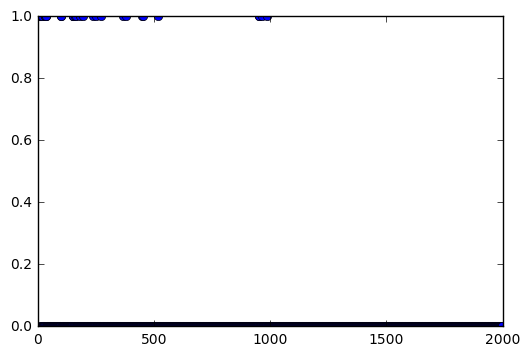

In [28]:
plt.plot(fit.get_sampler_params()[3]['divergent__'], 'o')

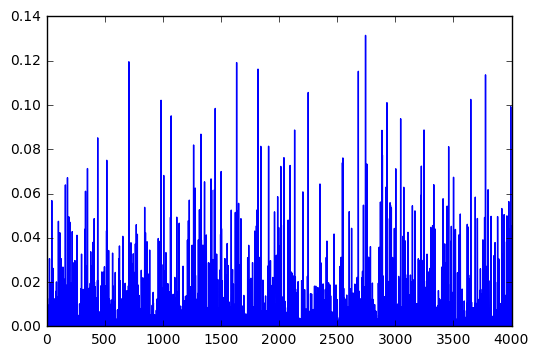

In [29]:
plt.plot(fit.extract()['flux'][:,0,3])

In [30]:

outfile=output_folder+'source_'+str(i)+'_SPM.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'psw':prior250,'pmw':prior350,'plw':prior500,'samples':fit.extract(),'names':fit.flatnames},f)

In [31]:
fit.extract()['Nbb'].shape

(4000, 127)

In [32]:
from xidplus import posterior_maps as postmaps

hdulist_250=postmaps.make_fits_image(prior250,prior250.sim)
hdulist_350=postmaps.make_fits_image(prior350,prior350.sim)
hdulist_500=postmaps.make_fits_image(prior500,prior500.sim)


In [33]:
#Set some color info
import seaborn as sns
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
vmin=-1.7E1
vmax=4.446e+01

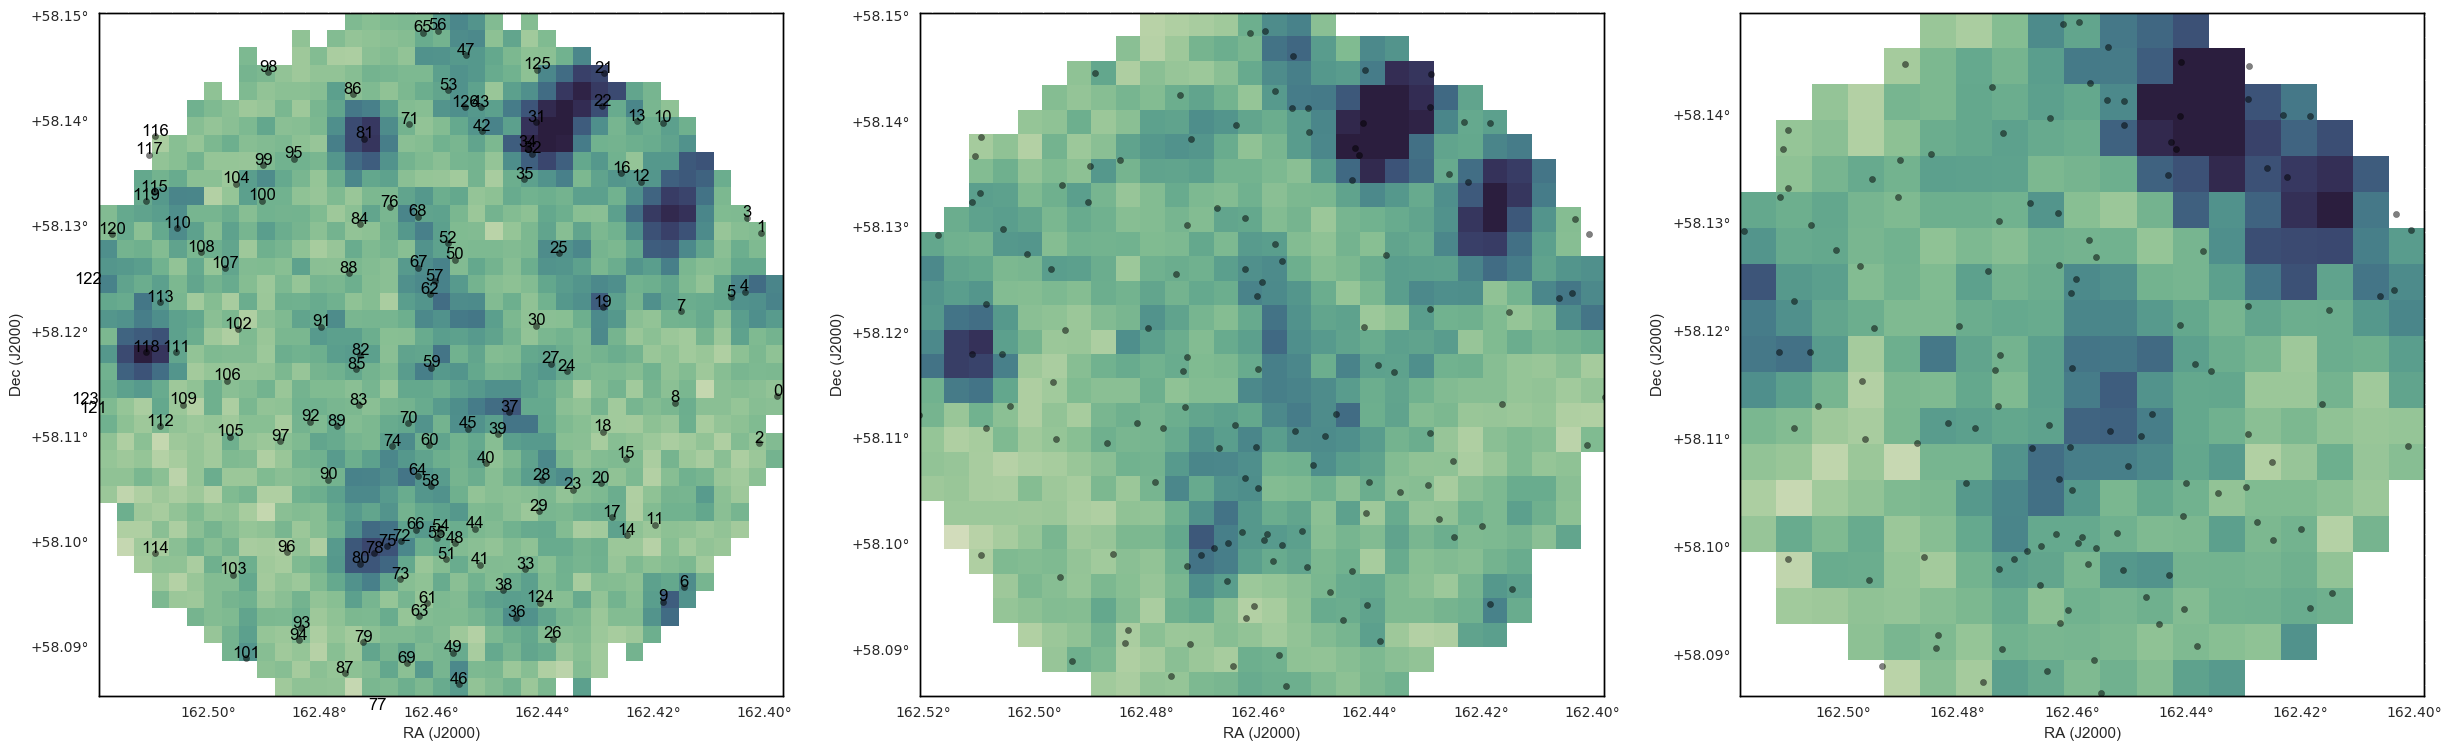

In [34]:
sns.set_style("whitegrid", {'axes.grid' : False})

import aplpy
fig = plt.figure(figsize=(30,10))
real_250 = aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
real_250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_250.tick_labels.set_xformat('dd.dd')
real_250.tick_labels.set_yformat('dd.dd')

real_350 = aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
real_350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_350.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_350.tick_labels.set_xformat('dd.dd')
real_350.tick_labels.set_yformat('dd.dd')
real_500 = aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
real_500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
real_500.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
real_500.tick_labels.set_xformat('dd.dd')
real_500.tick_labels.set_yformat('dd.dd')

for i in range(0,prior250.sra.size):

    real_250.add_label(prior250.sra[i], prior250.sdec[i]+0.0005, np.arange(0,prior250.nsrc)[i], relative=False)

In [35]:
mod_map=np.full((hdulist_250[1].data.shape[1],hdulist_250[1].data.shape[0],500),np.nan)
mod_map_array=np.empty((prior250.snpix,500))

for i in range(0,500):
    mod_map_array[:,i]= postmaps.ymod_map(prior250,posterior.stan_fit[i,0,0:prior250.nsrc]).reshape(-1)+posterior.stan_fit[i,0,prior250.nsrc]+np.random.normal(scale=np.sqrt(prior250.snim**2+posterior.stan_fit[i,0,(prior250.nsrc+1)*3]**2))         
    mod_map[prior250.sx_pix-np.min(prior250.sx_pix)-1,prior250.sy_pix-np.min(prior250.sy_pix)-1,i]=mod_map_array[:,i]

In [36]:
mod_map_350=np.full((hdulist_350[1].data.shape[1],hdulist_350[1].data.shape[0],500),np.nan)
mod_map_array_350=np.empty((prior350.snpix,500))

for i in range(0,500):
    mod_map_array_350[:,i]= postmaps.ymod_map(prior350,posterior.stan_fit[i,0,prior350.nsrc+1:2*prior350.nsrc+1]).reshape(-1)+posterior.stan_fit[i,0,2*prior350.nsrc+1]+np.random.normal(scale=np.sqrt(prior350.snim**2+posterior.stan_fit[i,0,1+(prior350.nsrc+1)*3]**2))         
    mod_map_350[prior350.sx_pix-np.min(prior350.sx_pix)-1,prior350.sy_pix-np.min(prior350.sy_pix)-1,i]=mod_map_array_350[:,i]

In [37]:
mod_map_500=np.full((hdulist_500[1].data.shape[1],hdulist_500[1].data.shape[0],500),np.nan)
mod_map_array_500=np.empty((prior500.snpix,500))

for i in range(0,500):
    mod_map_array_500[:,i]= postmaps.ymod_map(prior500,posterior.stan_fit[i,0,2*prior500.nsrc+2:3*prior350.nsrc+2]).reshape(-1)+posterior.stan_fit[i,0,3*prior500.nsrc+2]+np.random.normal(scale=np.sqrt(prior500.snim**2+posterior.stan_fit[i,0,2+(prior500.nsrc+1)*3]**2))         
    mod_map_500[prior500.sx_pix-np.min(prior500.sx_pix)-1,prior500.sy_pix-np.min(prior500.sy_pix)-1,i]=mod_map_array_500[:,i]

In [38]:
from tempfile import NamedTemporaryFile
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
from matplotlib import animation
from IPython.display import HTML


def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [39]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(30,10))
res250=aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res250.tick_labels.set_xformat('dd.dd')
res250.tick_labels.set_yformat('dd.dd')

res350=aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res350.tick_labels.set_xformat('dd.dd')
res350.tick_labels.set_yformat('dd.dd')

res500=aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res500.tick_labels.set_xformat('dd.dd')
res500.tick_labels.set_yformat('dd.dd')


# animation function.  This is called sequentially
def animate(i):
    res250._data=mod_map[:,:,i].T
    res350._data=mod_map_350[:,:,i].T
    res500._data=mod_map_500[:,:,i].T

    res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
    res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
    res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)


    return [res250,res350,res500]
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=50, interval=1000)

#anim.save('test_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
display_animation(anim)

In [40]:
samples=fit.extract()

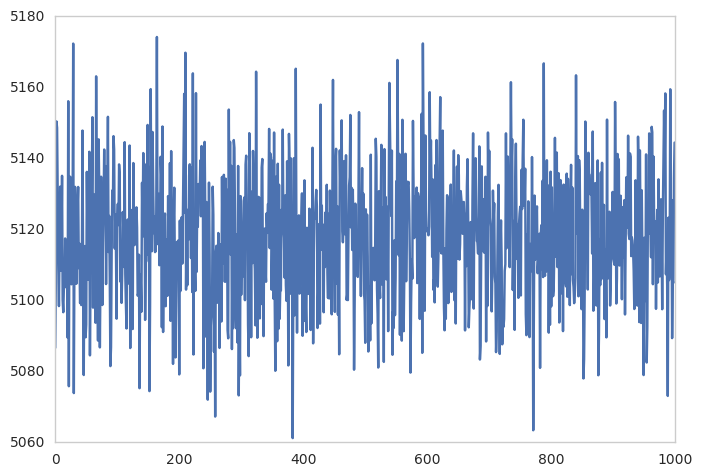

In [41]:
plt.plot(-1.0*samples['lp__'][1000:2000])

In [91]:
samples['lp__'].shape

(4000,)

In [42]:
mod_map_SPM=np.full((hdulist_250[1].data.shape[1],hdulist_250[1].data.shape[0],500),np.nan)
mod_map_array_SPM=np.empty((prior250.snpix,500))

for i in range(0,500):
    mod_map_array_SPM[:,i]= postmaps.ymod_map(prior250,samples['flux'][i,:,0]).reshape(-1)+samples['bkg_psw'][i]+np.random.normal(scale=np.sqrt(prior250.snim**2+samples['sigma_conf_psw'][i]**2))         
    mod_map_SPM[prior250.sx_pix-np.min(prior250.sx_pix)-1,prior250.sy_pix-np.min(prior250.sy_pix)-1,i]=mod_map_array_SPM[:,i]

In [43]:
mod_map_350_SPM=np.full((hdulist_350[1].data.shape[1],hdulist_350[1].data.shape[0],500),np.nan)
mod_map_array_350_SPM=np.empty((prior350.snpix,500))

for i in range(0,500):
    mod_map_array_350_SPM[:,i]= postmaps.ymod_map(prior350,samples['flux'][i,:,1]).reshape(-1)+samples['bkg_pmw'][i]+np.random.normal(scale=np.sqrt(prior350.snim**2+samples['sigma_conf_pmw'][i]**2))         
    mod_map_350_SPM[prior350.sx_pix-np.min(prior350.sx_pix)-1,prior350.sy_pix-np.min(prior350.sy_pix)-1,i]=mod_map_array_350_SPM[:,i]

In [44]:
mod_map_500_SPM=np.full((hdulist_500[1].data.shape[1],hdulist_500[1].data.shape[0],500),np.nan)
mod_map_array_500_SPM=np.empty((prior500.snpix,500))

for i in range(0,500):
    mod_map_array_500_SPM[:,i]= postmaps.ymod_map(prior500,samples['flux'][i,:,2]).reshape(-1)+samples['bkg_plw'][i]+np.random.normal(scale=np.sqrt(prior500.snim**2+samples['sigma_conf_plw'][i]**2))         
    mod_map_500_SPM[prior500.sx_pix-np.min(prior500.sx_pix)-1,prior500.sy_pix-np.min(prior500.sy_pix)-1,i]=mod_map_array_500_SPM[:,i]

In [45]:
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
vmin=-1.7E1
vmax=4.446e+01
#First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(30,10))
res250=aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res250.tick_labels.set_xformat('dd.dd')
res250.tick_labels.set_yformat('dd.dd')

res350=aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res350.tick_labels.set_xformat('dd.dd')
res350.tick_labels.set_yformat('dd.dd')

res500=aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)
res500.tick_labels.set_xformat('dd.dd')
res500.tick_labels.set_yformat('dd.dd')


# animation function.  This is called sequentially
def animate(i):
    res250._data=mod_map_SPM[:,:,i].T
    res350._data=mod_map_350_SPM[:,:,i].T
    res500._data=mod_map_500_SPM[:,:,i].T

    res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
    res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
    res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)


    return [res250,res350,res500]
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=50, interval=1000)

#anim.save('test_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

# call our new function to display the animation
display_animation(anim)

[0.0004960483454017209, 0.0014881450386016893, 0.009424918572218804, 0.041172012710282049]
[0.0004248137932683024, 0.0021240689595414725, 0.10110568252075439, 0.23364758565496263]


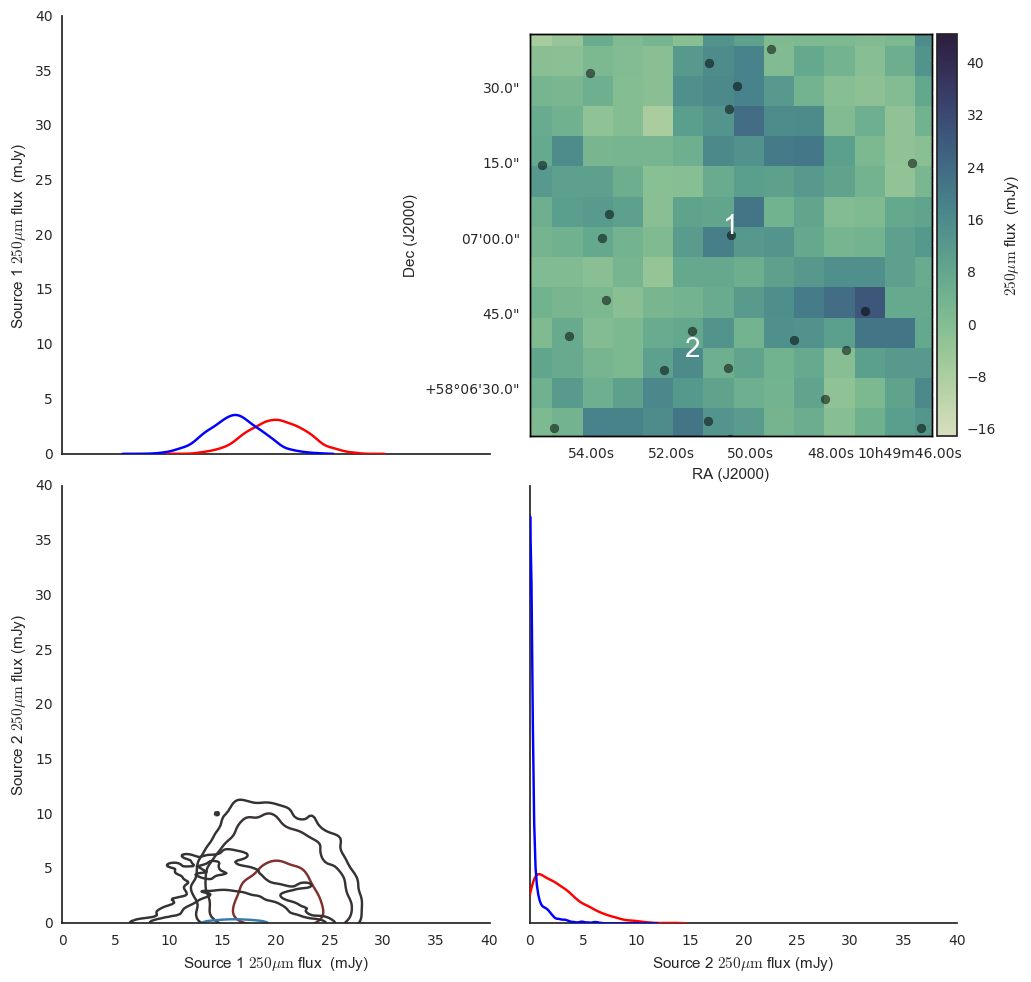

In [46]:
s1=59
s2=70
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
sns.set_style("white")
ra_zoom=prior250.sra[s1]
dec_zoom=prior250.sdec[s1]
radius=40/3600.0
import scipy
# Make a 2d normed histogram
H,xedges,yedges=np.histogram2d(posterior.stan_fit[:,:,[s1]].reshape(posterior.stan_fit.shape[0]*posterior.stan_fit.shape[1]),posterior.stan_fit[:,:,[s2]].reshape(posterior.stan_fit.shape[0]*posterior.stan_fit.shape[1]),bins=20,normed=True)

norm=H.sum() # Find the norm of the sum
# Set contour levels
contour1=0.99
contour2=0.95
contour3=0.68

# Set target levels as percentage of norm
target1 = norm*contour1
target2 = norm*contour2
target3 = norm*contour3

# Take histogram bin membership as proportional to Likelihood
# This is true when data comes from a Markovian process
def objective(limit, target):
    w = np.where(H>limit)
    count = H[w]
    return count.sum() - target

# Find levels by summing histogram to objective
level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

# For nice contour shading with seaborn, define top level
level4=H.max()
levels=[level1,level2,level3,level4]

print levels

labels=[r'Source 1 $250\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $250\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(posterior.stan_fit[:,:,[s1,s2]].reshape(3000,2),columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds_d",alpha=1.0,n_levels=levels,normed=True)
g.set(ylim=(0,40))
g.set(xlim=(0,40))

#---------SPM overlay---------------------
H,xedges,yedges=np.histogram2d(posterior.stan_fit[:,:,[s1]].reshape(posterior.stan_fit.shape[0]*posterior.stan_fit.shape[1]),posterior.stan_fit[:,:,[s2]].reshape(posterior.stan_fit.shape[0]*posterior.stan_fit.shape[1]),bins=20,normed=True)
H,xedges,yedges=np.histogram2d(samples['flux'][:,s1,0],samples['flux'][:,s2,0],bins=20,normed=True)

norm=H.sum() # Find the norm of the sum
# Set contour levels
contour1=0.99
contour2=0.95
contour3=0.68

# Set target levels as percentage of norm
target1 = norm*contour1
target2 = norm*contour2
target3 = norm*contour3

# Take histogram bin membership as proportional to Likelihood
# This is true when data comes from a Markovian process

# Find levels by summing histogram to objective
level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

# For nice contour shading with seaborn, define top level
level4=H.max()
levels=[level1,level2,level3,level4]

print levels

labels=[r'Source 1 $250\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $250\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(samples['flux'][:,[s1,s2],0],columns=labels)
g.data=df
g.map_diag(sns.kdeplot,c='Blue')
g.map_lower(sns.kdeplot, cmap="Blues_d",alpha=1.0,n_levels=levels,normed=True)




g.axes[0,1].spines['bottom'].set_color('white')
g.axes[0,1].spines['left'].set_color('white')
real_250 = aplpy.FITSFigure(hdulist_250[1],figure=g.fig,subplot=(2,2,2))
real_250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)

real_250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_250.recenter(ra_zoom, dec_zoom, radius=radius)

real_250.add_label(prior250.sra[s1], prior250.sdec[s1]+0.0005, 1, relative=False,size=20,color='white')
real_250.add_label(prior250.sra[s2], prior250.sdec[s2]-0.0010, 2, relative=False,size=20,color='white')



real_250.add_colorbar(axis_label_text=r'$250\mathrm{\mu m}$ flux  (mJy)')  


[0.0002993301835716066, 0.0011973207391997997, 0.007183924436836591, 0.028137037376927562]
[0.00040096055865747706, 0.0024057633507049794, 0.08781036231127076, 0.17040823736371394]


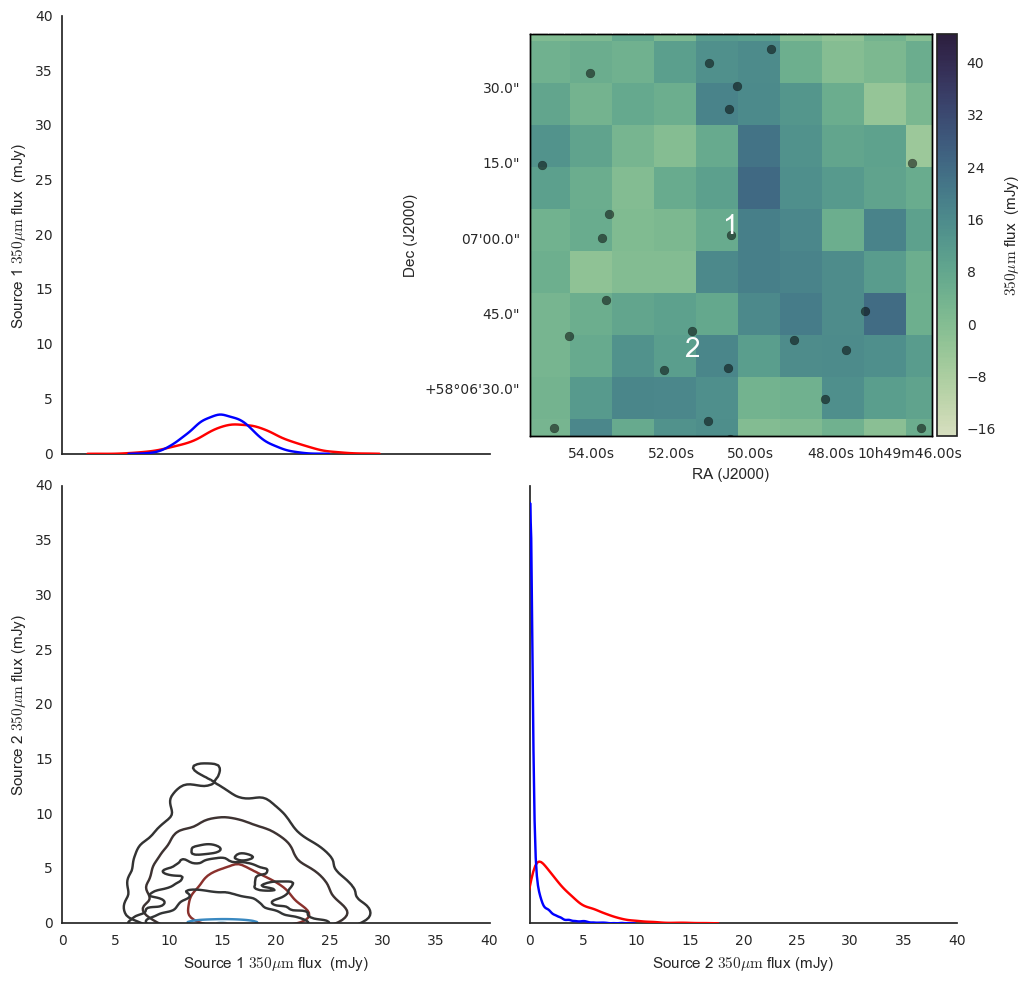

In [47]:
s1=59
s2=70
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
sns.set_style("white")
ra_zoom=prior250.sra[s1]
dec_zoom=prior250.sdec[s1]
radius=40/3600.0
import scipy
# Make a 2d normed histogram
H,xedges,yedges=np.histogram2d(posterior.stan_fit[:,:,[s1+prior350.nsrc+1]].reshape(posterior.stan_fit.shape[0]*posterior.stan_fit.shape[1]),posterior.stan_fit[:,:,[s2+prior350.nsrc+1]].reshape(posterior.stan_fit.shape[0]*posterior.stan_fit.shape[1]),bins=20,normed=True)

norm=H.sum() # Find the norm of the sum
# Set contour levels
contour1=0.99
contour2=0.95
contour3=0.68

# Set target levels as percentage of norm
target1 = norm*contour1
target2 = norm*contour2
target3 = norm*contour3

# Take histogram bin membership as proportional to Likelihood
# This is true when data comes from a Markovian process
def objective(limit, target):
    w = np.where(H>limit)
    count = H[w]
    return count.sum() - target

# Find levels by summing histogram to objective
level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

# For nice contour shading with seaborn, define top level
level4=H.max()
levels=[level1,level2,level3,level4]

print levels

labels=[r'Source 1 $350\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $350\mathrm{\mu m}$ flux (mJy)']

df = pd.DataFrame(posterior.stan_fit[:,:,prior350.nsrc+1+[s1,s2]].reshape(3000,2),columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds_d",alpha=1.0,n_levels=levels,normed=True)
g.set(ylim=(0,40))
g.set(xlim=(0,40))

#---------SPM overlay---------------------
H,xedges,yedges=np.histogram2d(samples['flux'][:,s1,1],samples['flux'][:,s2,1],bins=20,normed=True)

norm=H.sum() # Find the norm of the sum
# Set contour levels
contour1=0.99
contour2=0.95
contour3=0.68

# Set target levels as percentage of norm
target1 = norm*contour1
target2 = norm*contour2
target3 = norm*contour3

# Take histogram bin membership as proportional to Likelihood
# This is true when data comes from a Markovian process

# Find levels by summing histogram to objective
level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

# For nice contour shading with seaborn, define top level
level4=H.max()
levels=[level1,level2,level3,level4]

print levels

labels=[r'Source 1 $350\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $350\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(samples['flux'][:,[s1,s2],1],columns=labels)
g.data=df
g.map_diag(sns.kdeplot,c='Blue')
g.map_lower(sns.kdeplot, cmap="Blues_d",alpha=1.0,n_levels=levels,normed=True)




g.axes[0,1].spines['bottom'].set_color('white')
g.axes[0,1].spines['left'].set_color('white')
real_250 = aplpy.FITSFigure(hdulist_350[1],figure=g.fig,subplot=(2,2,2))
real_250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)

real_250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_250.recenter(ra_zoom, dec_zoom, radius=radius)

real_250.add_label(prior250.sra[s1], prior250.sdec[s1]+0.0005, 1, relative=False,size=20,color='white')
real_250.add_label(prior250.sra[s2], prior250.sdec[s2]-0.0010, 2, relative=False,size=20,color='white')



real_250.add_colorbar(axis_label_text=r'$350\mathrm{\mu m}$ flux  (mJy)')  


[0.00022279497784036083, 0.0008911799128139013, 0.00512428449613813, 0.024953037541359736]
[0.0006504063803250993, 0.0026016255193506773, 0.10601623995789623, 0.26796742860815326]


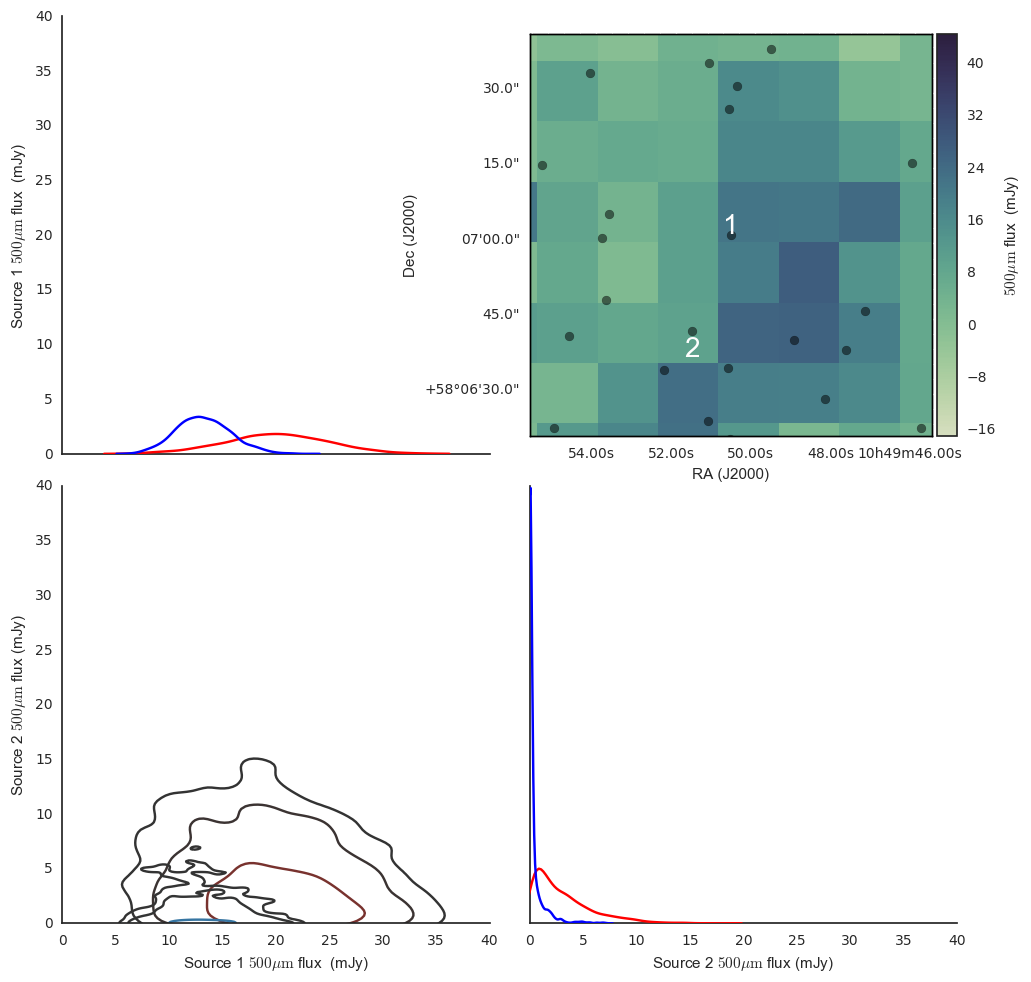

In [48]:
s1=59
s2=70
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
sns.set_style("white")
ra_zoom=prior250.sra[s1]
dec_zoom=prior250.sdec[s1]
radius=40/3600.0
import scipy
# Make a 2d normed histogram
H,xedges,yedges=np.histogram2d(posterior.stan_fit[:,:,[s1+2*prior500.nsrc+2]].reshape(posterior.stan_fit.shape[0]*posterior.stan_fit.shape[1]),posterior.stan_fit[:,:,[s2+2*prior500.nsrc+2]].reshape(posterior.stan_fit.shape[0]*posterior.stan_fit.shape[1]),bins=20,normed=True)

norm=H.sum() # Find the norm of the sum
# Set contour levels
contour1=0.99
contour2=0.95
contour3=0.68

# Set target levels as percentage of norm
target1 = norm*contour1
target2 = norm*contour2
target3 = norm*contour3

# Take histogram bin membership as proportional to Likelihood
# This is true when data comes from a Markovian process
def objective(limit, target):
    w = np.where(H>limit)
    count = H[w]
    return count.sum() - target

# Find levels by summing histogram to objective
level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

# For nice contour shading with seaborn, define top level
level4=H.max()
levels=[level1,level2,level3,level4]

print levels

labels=[r'Source 1 $500\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $500\mathrm{\mu m}$ flux (mJy)']

df = pd.DataFrame(posterior.stan_fit[:,:,2*prior500.nsrc+2+[s1,s2]].reshape(3000,2),columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds_d",alpha=1.0,n_levels=levels,normed=True)
g.set(ylim=(0,40))
g.set(xlim=(0,40))

#---------SPM overlay---------------------
H,xedges,yedges=np.histogram2d(samples['flux'][:,s1,1],samples['flux'][:,s2,2],bins=20,normed=True)

norm=H.sum() # Find the norm of the sum
# Set contour levels
contour1=0.99
contour2=0.95
contour3=0.68

# Set target levels as percentage of norm
target1 = norm*contour1
target2 = norm*contour2
target3 = norm*contour3

# Take histogram bin membership as proportional to Likelihood
# This is true when data comes from a Markovian process

# Find levels by summing histogram to objective
level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

# For nice contour shading with seaborn, define top level
level4=H.max()
levels=[level1,level2,level3,level4]

print levels

labels=[r'Source 1 $500\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $500\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(samples['flux'][:,[s1,s2],2],columns=labels)
g.data=df
g.map_diag(sns.kdeplot,c='Blue')
g.map_lower(sns.kdeplot, cmap="Blues_d",alpha=1.0,n_levels=levels,normed=True)




g.axes[0,1].spines['bottom'].set_color('white')
g.axes[0,1].spines['left'].set_color('white')
real_250 = aplpy.FITSFigure(hdulist_500[1],figure=g.fig,subplot=(2,2,2))
real_250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)

real_250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_250.recenter(ra_zoom, dec_zoom, radius=radius)

real_250.add_label(prior250.sra[s1], prior250.sdec[s1]+0.0005, 1, relative=False,size=20,color='white')
real_250.add_label(prior250.sra[s2], prior250.sdec[s2]-0.0010, 2, relative=False,size=20,color='white')



real_250.add_colorbar(axis_label_text=r'$500\mathrm{\mu m}$ flux  (mJy)')  


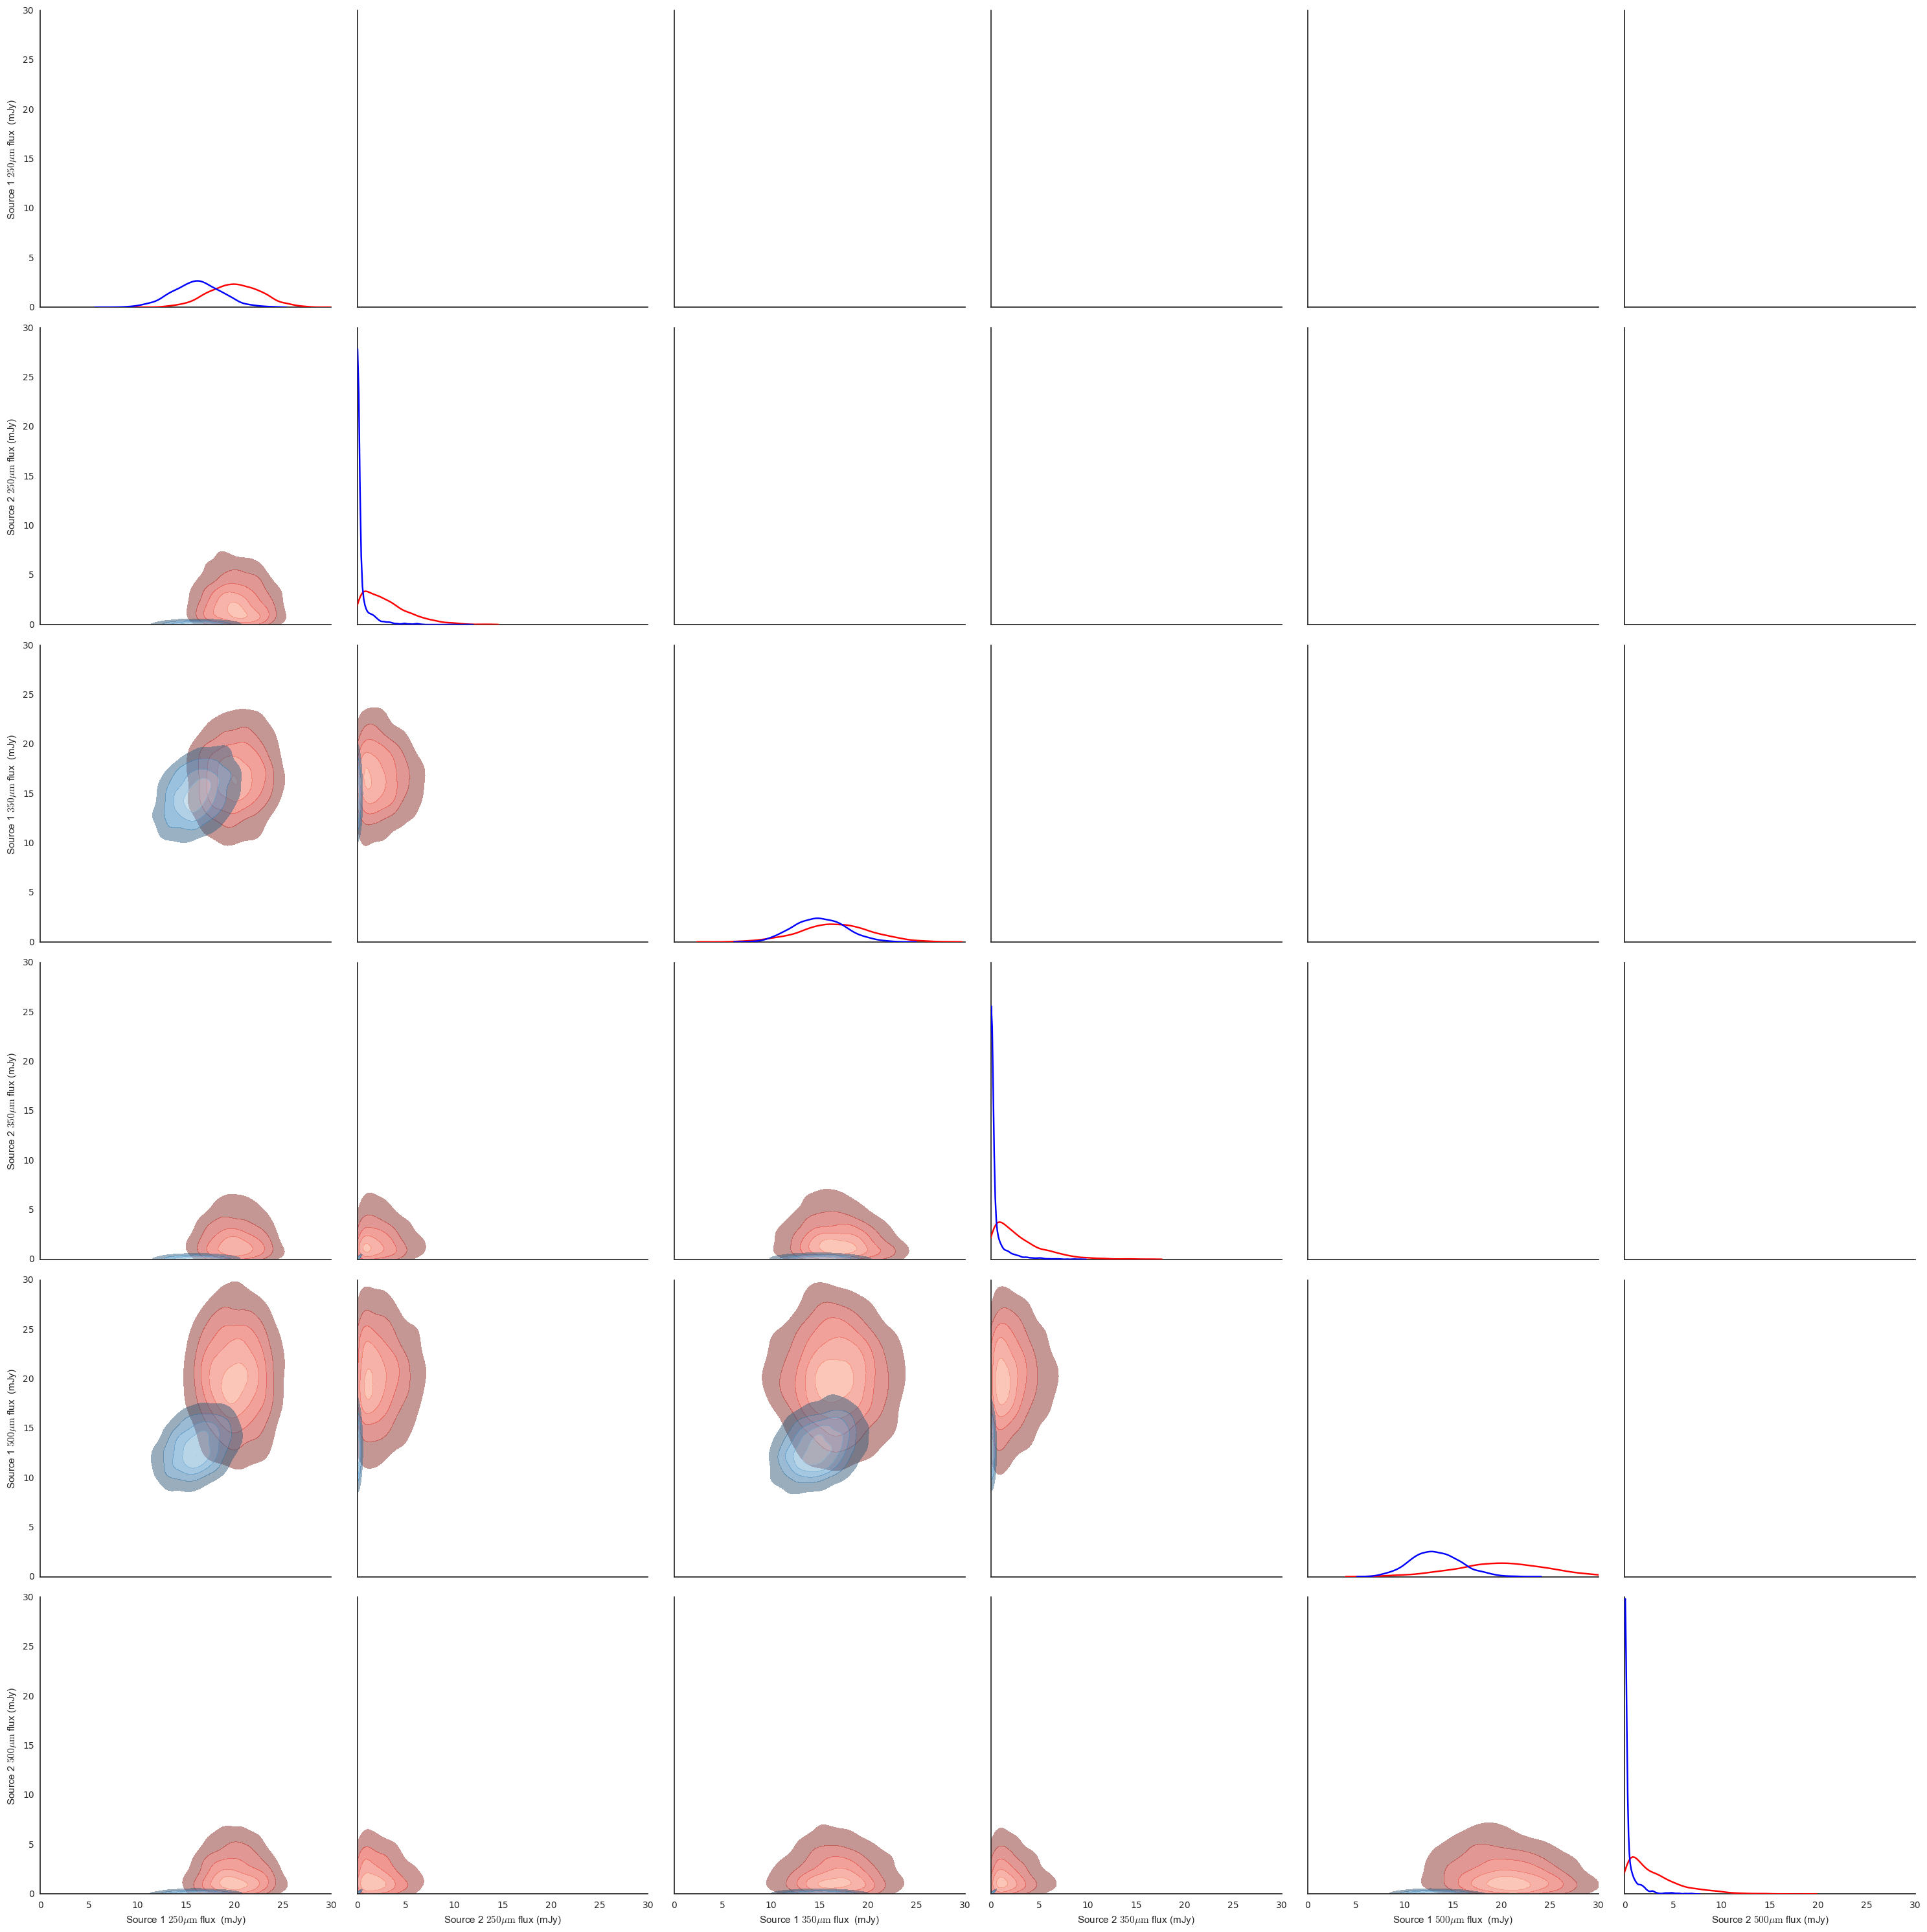

In [49]:
labels=[r'Source 1 $250\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $250\mathrm{\mu m}$ flux (mJy)',r'Source 1 $350\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $350\mathrm{\mu m}$ flux (mJy)',r'Source 1 $500\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $500\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(posterior.stan_fit[:,:,np.hstack((np.array([s1,s2]),prior350.nsrc+1+[s1,s2],2*prior500.nsrc+2+[s1,s2]))].reshape(3000,6),columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds_d",n_levels=5,normed=True,shade=True,shade_lowest=False, alpha=0.5)
df = pd.DataFrame(samples['flux'][:,[s1,s2],0:3].reshape(4000,6,order='F'),columns=labels)
g.data=df
g.map_diag(sns.kdeplot,c='Blue')
g.map_lower(sns.kdeplot, cmap="Blues_d",n_levels=5,normed=True,shade=True,shade_lowest=False, alpha=0.5)
g.set(ylim=(0,30))
g.set(xlim=(0,30))

(array([   0.,    0.,    0.,    1.,    1.,    0.,    3.,   11.,   17.,
          35.,   56.,   98.,  133.,  167.,  225.,  261.,  294.,  315.,
         322.,  284.,  279.,  251.,  233.,  179.,  147.,  107.,   92.,
          85.,   71.,   53.,   40.,   29.,   35.,   18.,   10.,   21.,
           9.,   16.,    7.,    8.,   12.,    8.,    7.,    5.,    4.,
           3.,    4.,    3.,    3.,    1.,    8.,    3.,    4.,    3.,
           3.,    2.,    0.,    0.,    1.,    1.,    2.,    1.,    0.,
           0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    1.,    0.,    0.,    2.,    0.,    1.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

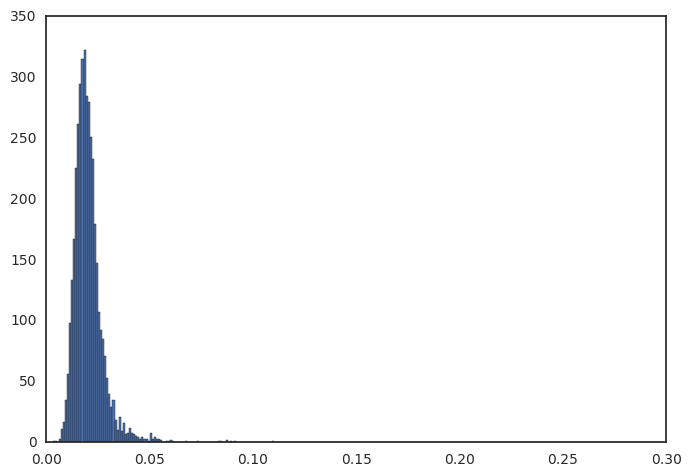

In [51]:
plt.hist(samples['flux'][:,[s1],3], bins=np.arange(0,0.3,0.001))


In [62]:
import scipy.stats as st

pval_250=np.empty_like(prior250.sim)
for i in range(0,prior250.snpix):
    ind=mod_map_array[i,:]<prior250.sim[i]
    pval_250[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array.shape[1]))
pval_250[np.isposinf(pval_250)]=6
    
pval_350=np.empty_like(prior350.sim)
for i in range(0,prior350.snpix):
    ind=mod_map_array_350[i,:]<prior350.sim[i]
    pval_350[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_350.shape[1]))
pval_350[np.isposinf(pval_350)]=6
    
pval_500=np.empty_like(prior500.sim)
for i in range(0,prior500.snpix):
    ind=mod_map_array_500[i,:]<prior500.sim[i]
    pval_500[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_500.shape[1]))
pval_500[np.isposinf(pval_500)]=6

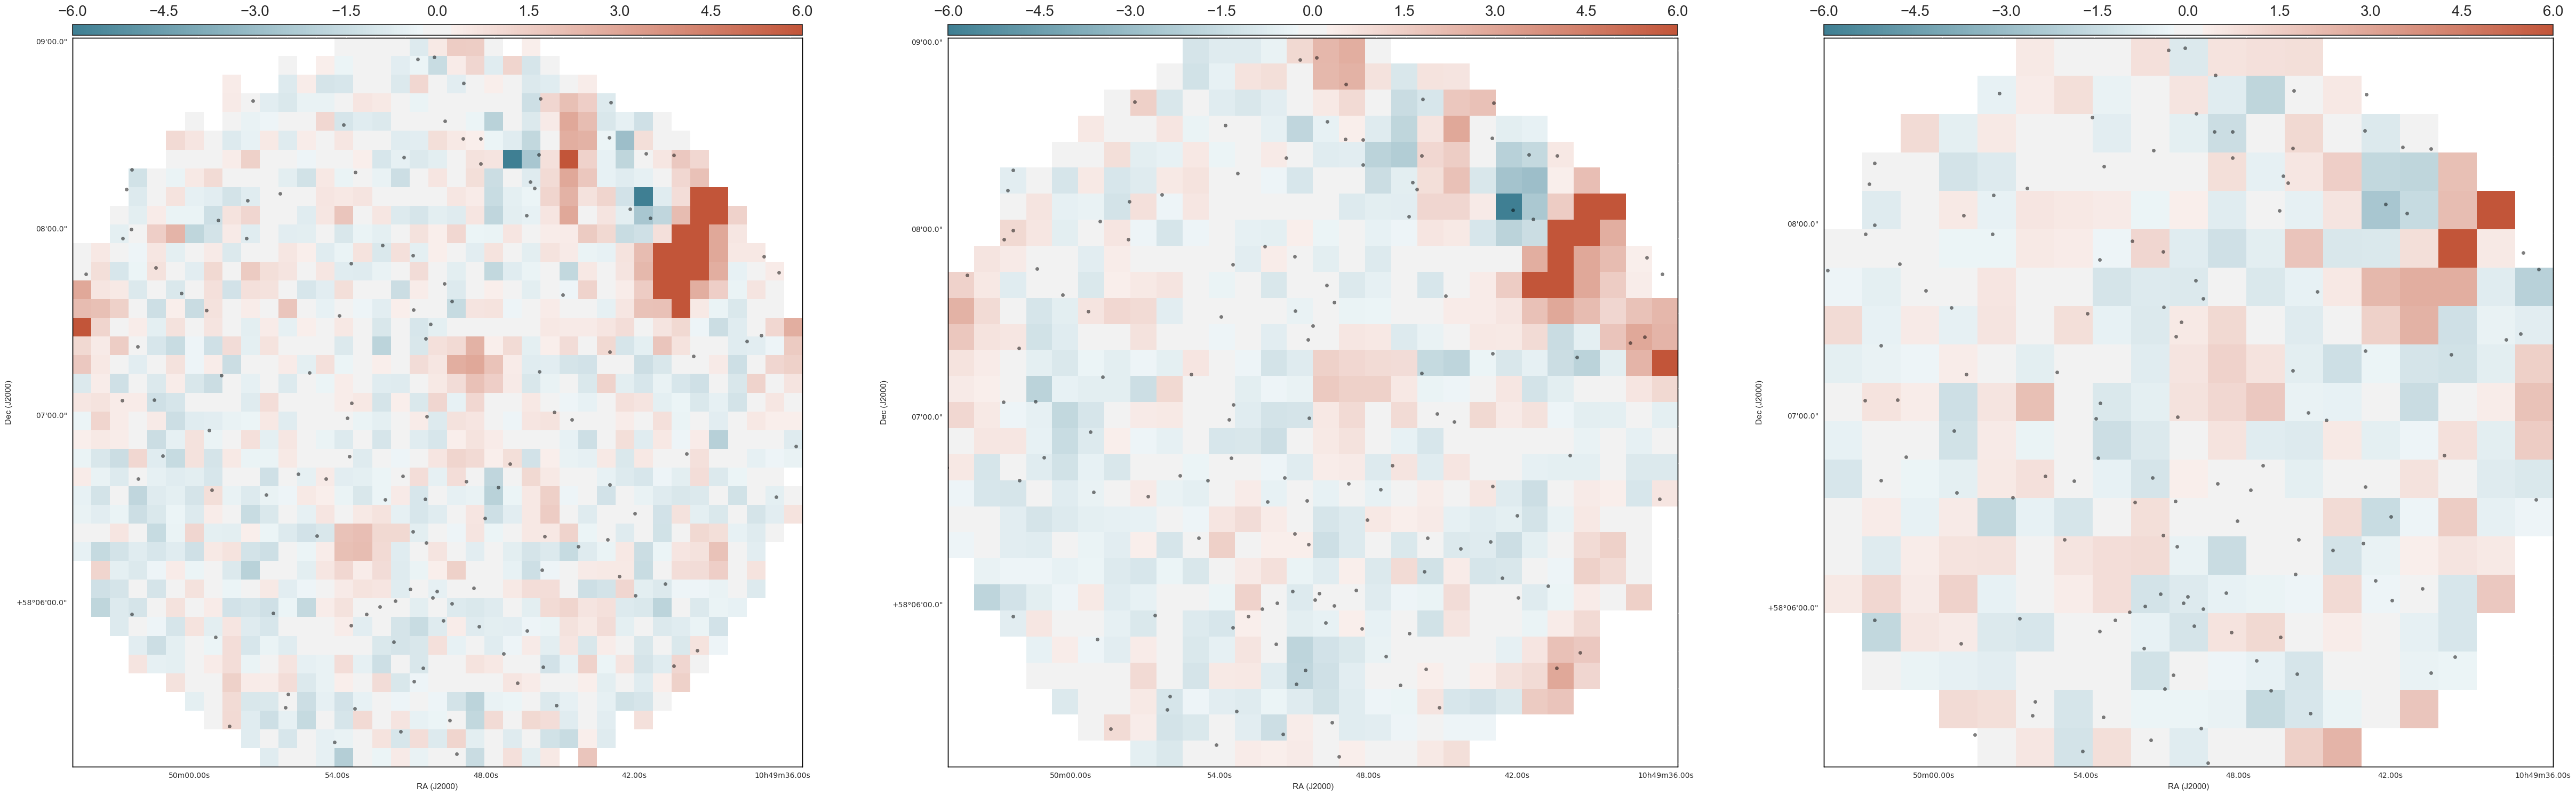

In [53]:
vmin=-6
vmax=6
cmap=sns.diverging_palette(220, 20,as_cmap=True)
from pylab import rcParams
rcParams.update({'font.size': 20})

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(60,20))
res250=aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)


res350=aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)

res500=aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=20, alpha=0.5)


res250._data[prior250.sy_pix-np.min(prior250.sy_pix)-1,prior250.sx_pix-np.min(prior250.sx_pix)-1]=pval_250
res350._data[prior350.sy_pix-np.min(prior350.sy_pix)-1,prior350.sx_pix-np.min(prior350.sx_pix)-1]=pval_350
res500._data[prior500.sy_pix-np.min(prior500.sy_pix)-1,prior500.sx_pix-np.min(prior500.sx_pix)-1]=pval_500



res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.add_colorbar()
res250.colorbar.set_location('top')
res350.add_colorbar()
res350.colorbar.set_location('top')
res500.add_colorbar()
res500.colorbar.set_location('top')


In [63]:
import scipy.stats as st

pval_250_SPM=np.empty_like(prior250.sim)
for i in range(0,prior250.snpix):
    ind=mod_map_array_SPM[i,:]<prior250.sim[i]
    pval_250_SPM[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_SPM.shape[1]))
pval_250_SPM[np.isposinf(pval_250_SPM)]=6
    
pval_350_SPM=np.empty_like(prior350.sim)
for i in range(0,prior350.snpix):
    ind=mod_map_array_350_SPM[i,:]<prior350.sim[i]
    pval_350_SPM[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_350_SPM.shape[1]))
pval_350_SPM[np.isposinf(pval_350_SPM)]=6
    
pval_500_SPM=np.empty_like(prior500.sim)
for i in range(0,prior500.snpix):
    ind=mod_map_array_500_SPM[i,:]<prior500.sim[i]
    pval_500_SPM[i]=st.norm.ppf(sum(ind)/np.float(mod_map_array_500_SPM.shape[1]))
pval_500_SPM[np.isposinf(pval_500_SPM)]=6

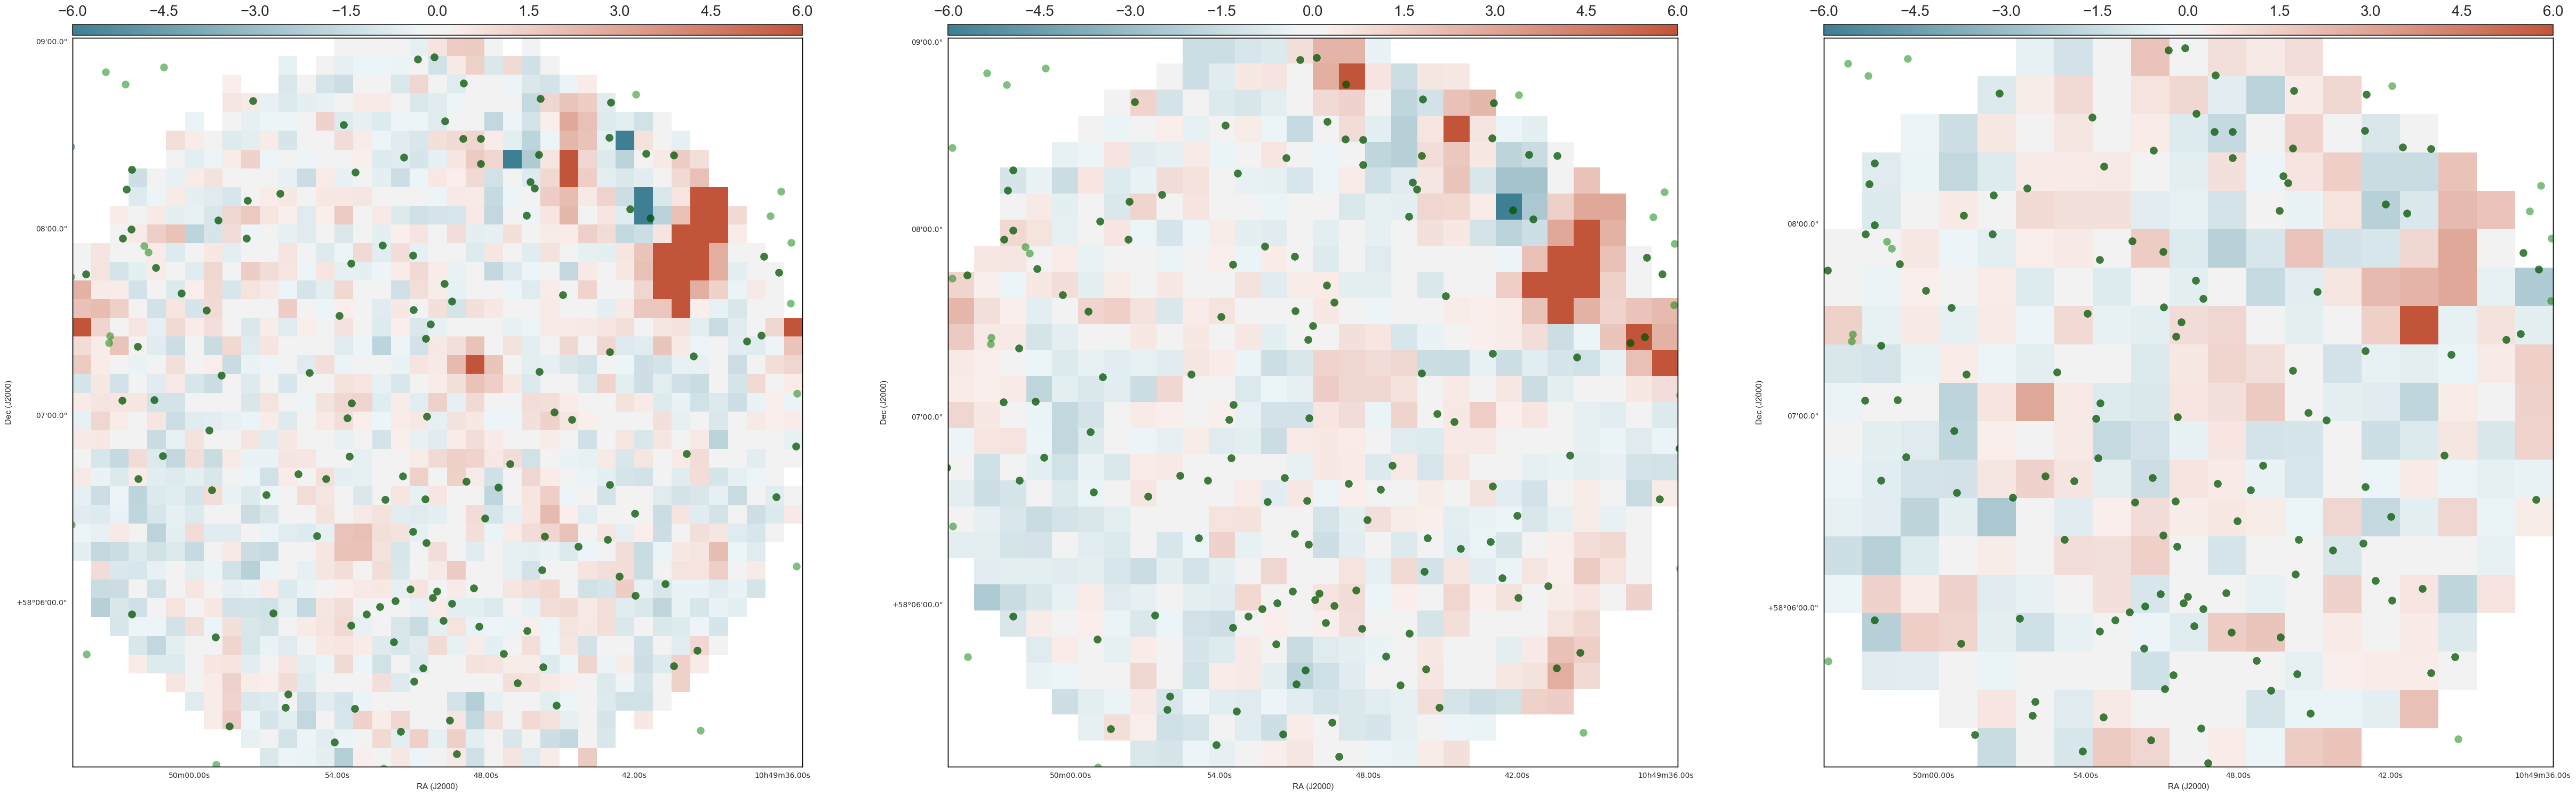

In [64]:
vmin=-6
vmax=6
cmap=sns.diverging_palette(220, 20,as_cmap=True)
from pylab import rcParams
rcParams.update({'font.size': 20})

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(60,20))
res250=aplpy.FITSFigure(hdulist_250[1],figure=fig,subplot=(1,3,1))
res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.show_markers(prior250.sra, prior250.sdec, edgecolor='black', facecolor='black',
                marker='o', s=100, alpha=0.5)
res250.show_markers(MRR['ra'], MRR['dec'], edgecolor='green', facecolor='green',
                marker='o', s=100, alpha=0.5)


res350=aplpy.FITSFigure(hdulist_350[1],figure=fig,subplot=(1,3,2))
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_markers(prior350.sra, prior350.sdec, edgecolor='black', facecolor='black',
                marker='o', s=100, alpha=0.5)
res350.show_markers(MRR['ra'], MRR['dec'], edgecolor='green', facecolor='green',
                marker='o', s=100, alpha=0.5)
res500=aplpy.FITSFigure(hdulist_500[1],figure=fig,subplot=(1,3,3))
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_markers(prior500.sra, prior500.sdec, edgecolor='black', facecolor='black',
                marker='o', s=100, alpha=0.5)
res500.show_markers(MRR['ra'], MRR['dec'], edgecolor='green', facecolor='green',
                marker='o', s=100, alpha=0.5)

res250._data[prior250.sy_pix-np.min(prior250.sy_pix)-1,prior250.sx_pix-np.min(prior250.sx_pix)-1]=pval_250_SPM
res350._data[prior350.sy_pix-np.min(prior350.sy_pix)-1,prior350.sx_pix-np.min(prior350.sx_pix)-1]=pval_350_SPM
res500._data[prior500.sy_pix-np.min(prior500.sy_pix)-1,prior500.sx_pix-np.min(prior500.sx_pix)-1]=pval_500_SPM



res250.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res350.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res500.show_colorscale(vmin=vmin,vmax=vmax,cmap=cmap)
res250.add_colorbar()
res250.colorbar.set_location('top')
res350.add_colorbar()
res350.colorbar.set_location('top')
res500.add_colorbar()
res500.colorbar.set_location('top')

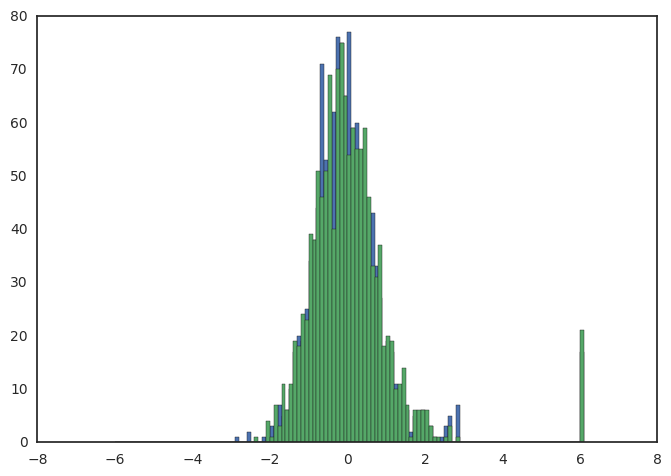

In [65]:
dist=plt.hist(pval_250[np.isfinite(pval_250)], bins=np.arange(-6.1,6.2,0.1))
dist_SPM=plt.hist(pval_250_SPM[np.isfinite(pval_250_SPM)], bins=np.arange(-6.1,6.2,0.1))

(array([   6.,   28.,  137.,  481.,  797.,  873.,  507.,  143.,   26.,    2.]),
 array([-2.78777541, -2.56641805, -2.34506069, -2.12370334, -1.90234598,
        -1.68098862, -1.45963126, -1.2382739 , -1.01691654, -0.79555918,
        -0.57420183]),
 <a list of 10 Patch objects>)

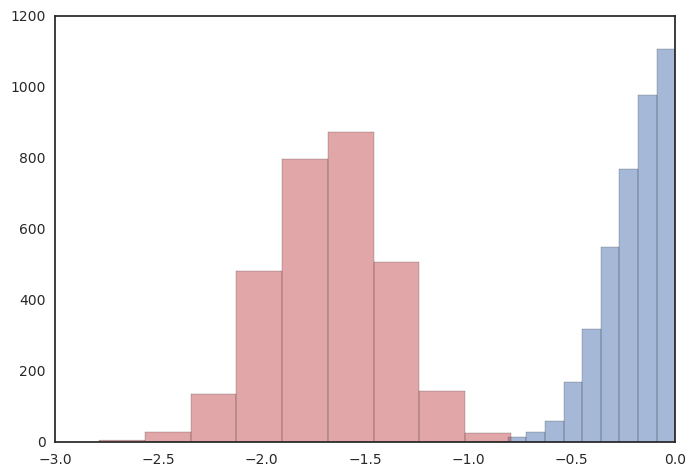

In [61]:
plt.hist(samples['bkg_psw'], color='b', alpha=0.5)
plt.hist(posterior.stan_fit[:,:,prior250.nsrc].flatten(), color='r', alpha=0.5)

## Plot SED

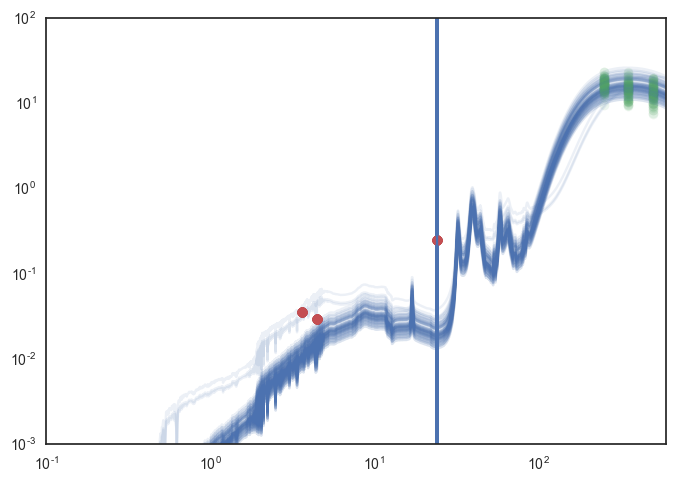

In [135]:
s1=59
from astropy.cosmology import Planck13
import astropy.units as u
import os
GOODS_S=np.array([10,12,7,31,29,1])
temps=os.listdir('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/')

for s in range(0,100):
    z=red[s1]

    div=(4.0*np.pi * np.square(Planck13.luminosity_distance(z).cgs))
    div=div.value
    
    template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[GOODS_S[np.random.multinomial(1, samples['p'][s,s1,:])==1].item()])

    flux=np.power(10.0,samples['Nbb'][s,s1])*(1.0+z)*(template['col2']*((template['col1']/1E4)**2)/3E14)*1E30*3.826E33/div
    wave=template['col1']/1E4

    plt.loglog((z+1.0)*wave,flux, alpha=0.1,c='b')
    plt.plot([250,350,500],samples['flux'][s,s1,0:3], 'go', alpha=0.1)
    plt.plot([3.6,4.5,24], np.array([MRR['s36'][sgood][keep][s1]/1000.0,MRR['s45'][sgood][keep][s1]/1000.0,MRR['s24'][sgood][keep][s1]/1000.0]),'ro')
    plt.xlim(0.1,600)
    plt.ylim(1E-3,1E2)
    plt.axvline(x=24.0)

In [132]:
MRR[sgood][keep][s1]

<Row index=59>
nidir  nidopt     ra        dec      s36     s45     s58      s8     s24     s70     s160   err36   err45   err58    err8   err24   err70   err160   am1     am2     am3     am4     am5     em1     em2     em3     em4     em5     am21    am22    am23    am25    am26    em21    em22    em23    em25    em26    am6     am7     am8     em6     em7     em8    mst   delmag delmag1   j1    alz     err0    j2    alz2    av1     err1   n91  nbopt   amb2    alb   spectz0 nzclass0 nzref0  nir    alp1    alp2    alp3    alp4   errir3  alcirr   alsb   alagn   ala220   alir  nirtem  als70   als160  als350  als450  als850 als1250   al36    alm     sfr     almd   chi2_1  chi2_2  chi2_3  chi2_4  chi2_5  chi2_6  chi2_7  chi2_8  chi2_9 chi2_10 chi2_11 chi2_12 chi2_13 chi2_14 chi2_15 chi2_16 chi2_17 chi2_18 chi2_19 chi2_20 chi2_21 chi2_22 chi2_23 chi2_24 chi2_25 chi2_26 chi2_27 chi2_28 chi2_29 chi2_30 chi2_31 chi2_32 chi2_33 chi2_34 chi2_35 chi2_36 chi2_37 chi2_38 chi2_39 chi2_40 chi2_41 chi2_42 chi2_43 chi2_44 chi2_45 chi2_46 chi2_47 chi2_48 chi2_49 chi2_50 chi2_51 chi2_52 chi2_53 chi2_54 chi2_55 chi2_56 chi2_57 chi2_58 chi2_59 chi2_60 chi2_61 chi2_62 chi2_63 chi2_64 chi2_65 chi2_66 chi2_67 chi2_68 chi2_69 chi2_70 chi2_71 chi2_72 chi2_73 chi2_74 chi2_75 chi2_76 chi2_77 chi2_78 chi2_79 chi2_80 chi2_81 chi2_82 chi2_83 chi2_84 chi2_85
int32  int32   float64    float64  float64 float64 float64 float64 float64 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float64 float32 float32 float32 float64 float32 float32 float32 float32 float32 float32 int16 float32 float32 int16 float32 float32 int16 float32 float32 float32 int16 int16 float32 float32 float32  int16   int16  int16 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 int16  float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32 float32
------ ------ ---------- --------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ----- ------- ------- ----- ------- ------- ----- ------- ------- ------- ----- ----- ------- ------- ------- -------- ------ ----- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------ ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- -------